# Fashion Mnist Dataset Convolutional Neural Network with Transfer Learning using Pytorch

## Import Libraries

In [1]:
# installing torchinfo library for viewing model summary
import sys
import subprocess
import importlib.util

package_name = 'torchinfo'

if importlib.util.find_spec(package_name) is None:
    print(f"Installing {package_name}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
else:
    print(f"{package_name} is already installed. Skipping.")

: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import kagglehub
import random
import matplotlib.pyplot as plt
from torchinfo import summary

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Loading the Dataset

In [4]:
dataset_path = kagglehub.dataset_download('zalando-research/fashionmnist')
csv_file_path = f'{dataset_path}/fashion-mnist_train.csv'
df_train = pd.read_csv(csv_file_path)

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_train.shape

(60000, 785)

In [7]:
csv_file_path = f'{dataset_path}/fashion-mnist_test.csv'
df_test = pd.read_csv(csv_file_path)

In [8]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_test.shape

(10000, 785)

## Viewing the Random Image

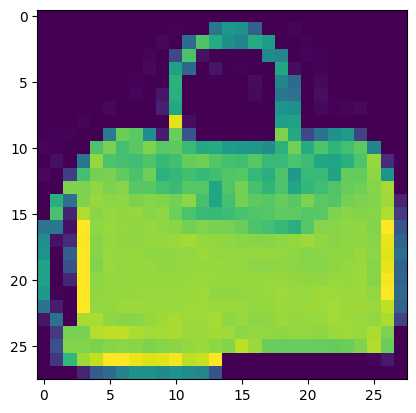

In [10]:
# train image
random_index = random.randint(0,len(df_train))
image = df_train.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

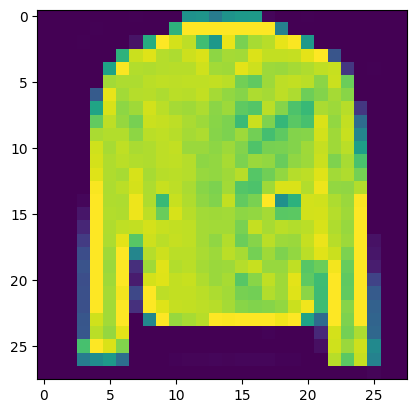

In [11]:
# test image
random_index = random.randint(0,len(df_test))
image = df_test.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

## Splitting the Dataset into Training and Testing Sets

In [12]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

## Transforming the Data for Transfer Learning with Pre-trained Models (VGG16)

In [13]:
from torchvision.transforms import transforms

custom_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

## Creating Custom Dataset Class

In [14]:
from PIL import Image

class CustomDataset(Dataset):

    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):

        # resize image to (28,28)
        image = self.features[index].reshape(28,28)
        
        # convert datatype to np.uint8
        image = image.astype(np.uint8)

        # convert black&white to color -> (H,W,C) -> (C,H,W)
        image = np.stack([image]*3, axis=-1)

        # convert image to PIL image
        image = Image.fromarray(image)

        # apply transformation
        image = self.transform(image)

        return image, torch.tensor(self.labels[index], dtype=torch.long)

In [15]:
train_datataset = CustomDataset(features=X_train, labels=y_train, transform=custom_transform)
test_datataset = CustomDataset(features=X_test, labels=y_test, transform=custom_transform)

In [16]:
train_dataloader = DataLoader(train_datataset, batch_size=128, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_datataset, batch_size=128, shuffle=False, pin_memory=True)

## Model Building, Training and Evaluation

In [17]:
# fetching pretrained model
from torchvision.models import vgg16, VGG16_Weights

vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

In [18]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [19]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [20]:
# disabling training of features part of model
for param in vgg16.features.parameters():
    param.requires_grad=False

In [21]:
# making our classfier part of model
vgg16.classifier = nn.Sequential(
    # hidden layer 1
    nn.Linear(in_features=25088, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # hidden layer 2
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # output layer
    nn.Linear(in_features=512, out_features=10)
)

In [22]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
learning_rate=0.0001
epochs=5

In [24]:
# creatind model object of Mode Class we creates above
vgg16 = vgg16.to(device)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(params=vgg16.classifier.parameters(), lr=learning_rate)

In [31]:
print(summary(vgg16, input_size=(128, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [128, 64, 224, 224]       (1,792)
│    └─ReLU: 2-2                         [128, 64, 224, 224]       --
│    └─Conv2d: 2-3                       [128, 64, 224, 224]       (36,928)
│    └─ReLU: 2-4                         [128, 64, 224, 224]       --
│    └─MaxPool2d: 2-5                    [128, 64, 112, 112]       --
│    └─Conv2d: 2-6                       [128, 128, 112, 112]      (73,856)
│    └─ReLU: 2-7                         [128, 128, 112, 112]      --
│    └─Conv2d: 2-8                       [128, 128, 112, 112]      (147,584)
│    └─ReLU: 2-9                         [128, 128, 112, 112]      --
│    └─MaxPool2d: 2-10                   [128, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [128, 256, 56, 56]  

In [26]:
for batch_features, batch_labels in train_dataloader:
    print(batch_features.shape)
    break

torch.Size([128, 3, 224, 224])


In [27]:
# training loop
for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        y_pred = vgg16(batch_features)
        
        # loss calculate
        loss = loss_function(y_pred, batch_labels)
        
        # clear gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # calculate loss for each batchs
        total_epoch_loss += loss.item()

    # average loss of batches
    avg_loss = total_epoch_loss/len(train_dataloader)

    print(f"Epoch: {epoch + 1}, Loss:{avg_loss}")

Epoch: 1, Loss:0.3803804150935429
Epoch: 2, Loss:0.2147925829232883
Epoch: 3, Loss:0.16594570505816036
Epoch: 4, Loss:0.1324067533826396
Epoch: 5, Loss:0.10315297049944842


In [28]:
# setting model to evaluation mode
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in test_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = vgg16(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Test Data: {(correct/total)*100}%")

Accuracy on Test Data: 93.11%


In [30]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = vgg16(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Train Data: {(correct/total)*100}%")

Accuracy on Train Data: 98.11166666666666%
